# Dynamics Derivation for Quad Rotor
## By William Black, Mahala Peters, Alexis Whitaker, Brynn Giffin, and Brice Hall

## Setup

In [5]:
import sympy as sym
from sympy.physics.mechanics import *

init_vprinting()

## Calculate Dynamics

### Calculate Kinetic and Potential Energy

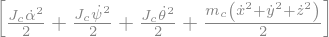

In [6]:
t = sym.symbols("t")
x, y, z, alpha, theta, psi = dynamicsymbols("x, y, z, alpha, theta, psi")
xdot, ydot, zdot, alphadot, thetadot, psidot = sym.diff(sym.Matrix([x, y, z, alpha, theta, psi]), t)
mc, m1, m2, m3, m4, mm, d = sym.symbols("m_c, m_1, m_2, m_3, m_4, m_M, d")
Jc = sym.symbols('J_c')
g = sym.symbols("g")

mm = 0

m1 = mm
m2 = mm
m3 = mm
m4 = mm

R_roll = sym.Matrix([
    [1, 0, 0],
    [0, sym.cos(theta), sym.sin(theta)],
    [0, -sym.sin(theta), sym.cos(theta)]
])

R_pitch = sym.Matrix([
    [sym.cos(alpha), 0, -sym.sin(alpha)],
    [0, 1, 0],
    [sym.sin(alpha), 0, sym.cos(alpha)]
])

R_yaw = sym.Matrix([
    [sym.cos(psi), sym.sin(psi), 0],
    [-sym.sin(psi), sym.cos(psi), 0],
    [0, 0, 1]
])

R_main = R_yaw.T@R_pitch.T@R_roll.T

pos_1_prime = sym.Matrix([
    [d*sym.sqrt(2)/2],
    [d*sym.sqrt(2)/2],
    [0]
])

pos_2_prime = sym.Matrix([
    [d*sym.sqrt(2)/2],
    [-d*sym.sqrt(2)/2],
    [0]
])

pos_3_prime = sym.Matrix([
    [-d*sym.sqrt(2)/2],
    [d*sym.sqrt(2)/2],
    [0]
])

pos_4_prime = sym.Matrix([
    [-d*sym.sqrt(2)/2],
    [-d*sym.sqrt(2)/2],
    [0]
])

pos_c = sym.Matrix([
    [x],
    [y],
    [z]
])

vel_c = sym.diff(pos_c, t)

pos_1 = R_main@pos_1_prime + pos_c
pos_2 = R_main@pos_2_prime + pos_c
pos_3 = R_main@pos_3_prime + pos_c
pos_4 = R_main@pos_4_prime + pos_c


vel_1 = sym.diff(pos_1, t)
vel_2 = sym.diff(pos_2, t)
vel_3 = sym.diff(pos_3, t)
vel_4 = sym.diff(pos_4, t)

rotational_velocities_prime = sym.Matrix([
    [thetadot],
    [alphadot],
    [psidot]
])

rotational_velocities = rotational_velocities_prime

rotational_inertias = sym.Matrix([
    [Jc + 4*(d*sym.sqrt(2)/2)**2*mm, 0, 0],
    [0, Jc + 4*(d*sym.sqrt(2)/2)**2*mm, 0],
    [0, 0, Jc + 4*d**2*mm]])

tke = sym.Rational(1,2)*((mc+m1+m2+m3+m4)*(vel_c.T@vel_c) + rotational_velocities.T@rotational_inertias@rotational_velocities)
pe = (mc+m1+m2+m3+m4)*z*g


display(sym.simplify(tke))
display(sym.simplify(pe))

In [7]:
def line_from_points(x1, y1, x2, y2):
    slope = sym.Rational(y2-y1, x2-x1)
    intercept = y1 - slope * x1

    return(slope, intercept)

### Calculate Input and Damping Matrices

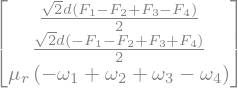

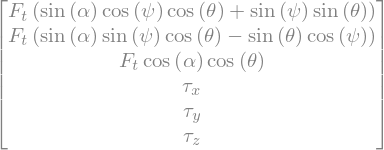

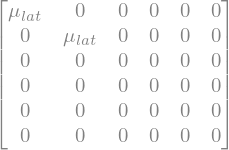

In [8]:
mu_r, mu_lat = sym.symbols("mu_r, mu_lat")
T1, T2, T3, T4 = sym.symbols("T_1, T_2, T_3, T_4")
F1, F2, F3, F4 = sym.symbols("F_1, F_2, F_3, F_4")
w1, w2, w3, w4 = sym.symbols("omega_1, omega_2, omega_3, omega_4")

Ft, tau_x, tau_y, tau_z = sym.symbols("F_t, tau_x, tau_y, tau_z")


# Throttle -> Thrust data points from table (relatively linear)
# (0.4, 2.26)
# (1.0, 9.122)

# Throttle -> RPM (converted to rad/s) data points from table (also linear)
# (0.4, 1900*2*sym.pi/60)
# (1.0, 3673*2*sym.pi/60)


# THRUST_SLOPE, THRUST_INTERCEPT = line_from_points(0.4, 2.26, 1.0, 9.122)
# ROTATION_SLOPE, ROTATION_INTERCEPT = line_from_points(0.4, (1900*2*sym.pi/60).evalf(), 1.0, (3673*2*sym.pi/60).evalf())

# F1 = THRUST_SLOPE * T1 + THRUST_INTERCEPT
# w1 = ROTATION_SLOPE * T1 + ROTATION_INTERCEPT

# F2 = THRUST_SLOPE * T2 + THRUST_INTERCEPT
# w2 = ROTATION_SLOPE * T2 + ROTATION_INTERCEPT

# F3 = THRUST_SLOPE * T3 + THRUST_INTERCEPT
# w3 = ROTATION_SLOPE * T3 + ROTATION_INTERCEPT

# F4 = THRUST_SLOPE * T4 + THRUST_INTERCEPT
# w4 = ROTATION_SLOPE * T4 + ROTATION_INTERCEPT


# force_inputs_prime = sym.Matrix([
#     [0],
#     [0],
#     [F1 + F2 + F3 + F4],
# ])

force_inputs_prime = sym.Matrix([
    [0],
    [0],
    [Ft],
])

torque_inputs_dprime = sym.Matrix([
    [d*(F3-F2)],
    [d*(F4-F1)],
    [mu_r * (w2 + w3 - w1 - w4)]
])

torque_inputs_prime = sym.Matrix([
    [tau_x],
    [tau_y],
    [tau_z]
])

R_diag = sym.Matrix([
    [sym.cos(-sym.pi/4), sym.sin(-sym.pi/4), 0],
    [-sym.sin(-sym.pi/4), sym.cos(-sym.pi/4), 0],
    [0, 0, 1]
])

R_diag_to_vehicle = R_main

display(sym.simplify(R_diag@torque_inputs_dprime))

force_inputs = R_diag_to_vehicle @ force_inputs_prime
torque_inputs = torque_inputs_prime

input_matrix = force_inputs.col_join(torque_inputs)

display(sym.simplify(input_matrix))

damping_matrix = sym.Matrix([
    [mu_lat, 0, 0, 0, 0, 0],
    [0, mu_lat, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0]
])

display(damping_matrix)

### Calculate Euler-Lagrange Equations

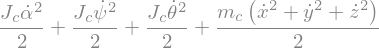

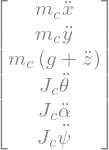

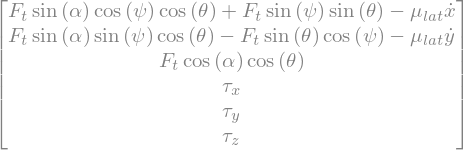

In [9]:
display(tke[0])
display(pe)

lagrange = tke[0] - pe

q = sym.Matrix([
    [x],
    [y],
    [z],
    [theta],
    [alpha],
    [psi]
])

qdot = sym.diff(q, t)

EL_lhs = sym.diff(sym.diff(lagrange, qdot), t) - sym.diff(lagrange, q)

EL_rhs = sym.ImmutableDenseMatrix(input_matrix - damping_matrix@qdot)

EL_lhs = sym.MutableDenseMatrix(sym.simplify(EL_lhs.cancel()))
EL_rhs = sym.MutableDenseMatrix(sym.simplify(EL_rhs.cancel()))

display(EL_lhs)
display(EL_rhs)

### Euler-Lagrange to Matrix Form

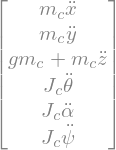

Remainder Matrix


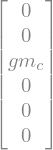

Euler Lagrange Matrices
 simplifying...


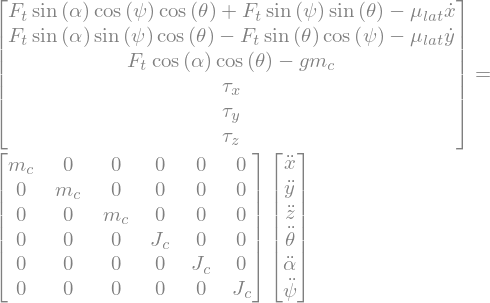

Equations of Motion


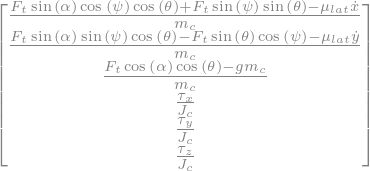

In [10]:
qddot = sym.diff(qdot, t)

remainder_matrix = sym.zeros(sym.shape(EL_lhs)[0], 1)
M_matrix = sym.zeros(sym.shape(EL_lhs)[0], sym.shape(EL_lhs)[0])

display(EL_lhs.expand())

temp = sym.symbols("V_temp")

for ind, i in enumerate(EL_lhs.expand()):
    for j in (i + temp).args:
        flag = False
        for indk, k in enumerate(qddot):
            for indl, l in enumerate(find_dynamicsymbols(j)):
                if k == l:
                    flag = True
                    M_matrix[indk, ind] = M_matrix[indk, ind] + j/l
            if k in find_dynamicsymbols(j):
                flag = True

        if not flag:
            remainder_matrix[ind] = remainder_matrix[ind] + j

        #if sym.diff(qdot, t) not in j:
            #display(j)



LHS = sym.ImmutableDenseMatrix(EL_lhs - remainder_matrix).cancel()
RHS = sym.ImmutableDenseMatrix(input_matrix - damping_matrix*qdot - remainder_matrix).subs({temp: 0}).cancel()

print("Remainder Matrix")
display(remainder_matrix.subs({temp: 0}))

print("Euler Lagrange Matrices")
euler_lagrange = sym.Eq(sym.MatMul(M_matrix, qddot, evaluate=False), RHS)

print(" simplifying...")
display(sym.simplify(euler_lagrange))

M_matrix = sym.ImmutableDenseMatrix(M_matrix)
M_matrix = sym.MutableDenseMatrix(M_matrix.cancel())
RHS = sym.MutableDenseMatrix(RHS.cancel())

display(RHS[3].collect([tau_x, tau_y, tau_z]))
display(RHS[4].collect([tau_x, tau_y, tau_z]))
display(RHS[5].collect([tau_x, tau_y, tau_z]))

print("Equations of Motion")
eqns = M_matrix.inv()@RHS
display(eqns)

## Generate State-Space

### General Algorithm

In [11]:
def linearize_space(eqns, x, y, u, equil):
    print("Equations")
    display(eqns)
    
    xdot = sym.diff(x, t)

    array_half = int(sym.shape(xdot)[0]//2)
    print(array_half)
    for i in range(array_half):
        print(i)
        xdot[i+array_half]=eqns[i]
    
    print("xdot")
    display(sym.simplify(xdot))

    # equilibrium = dict(zip(x, x_eq))
    # equilibrium.update(dict(zip(u, u_eq)))
    equilibrium =equil
    
    print("state & input")
    display(x)
    display(u)

    print("register & output")
    display(xdot)
    display(y)

    print("Equilibrium")
    display(equilibrium)
    
    A = xdot.jacobian(x).subs(equilibrium)
    B = xdot.jacobian(u).subs(equilibrium)

    C = y.jacobian(x).subs(equilibrium)
    D = y.jacobian(u).subs(equilibrium)

    return(A, B, C, D)

### F -> H loop

z
Equations


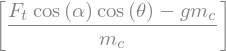

1
0
xdot


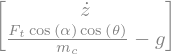

state & input


register & output


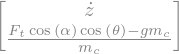

Equilibrium


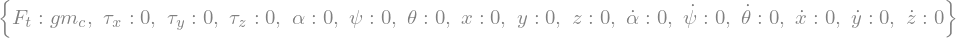

Linearized Matrices
A


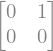

B


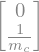

C


D


In [12]:
X = sym.Matrix([
    [z],
    [zdot]
])

Y = sym.Matrix([
    [z]
])

U = sym.Matrix([
    [Ft]
])

X_eq = (0, 0,)
U_eq = (g*mc,)
print(type(z))
equilibrium = {x: 0, y: 0, z: 0, xdot: 0, ydot: 0, zdot: 0, theta: 0, alpha: 0, psi: 0, thetadot: 0, alphadot: 0, psidot: 0, Ft: g*mc, tau_x: 0, tau_y: 0, tau_z: 0}

A, B, C, D = linearize_space([eqns[2]], X, Y, U, equilibrium)

print("Linearized Matrices")
print("A")
display(sym.simplify(A))
print("B")
display(sym.simplify(B))
print("C")
display(sym.simplify(C))
print("D")
display(sym.simplify(D))

### Tau_z -> psi Loop ####

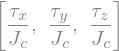

Equations


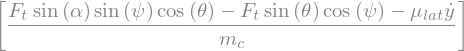

1
0
xdot


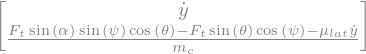

state & input


register & output


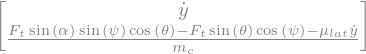

Equilibrium


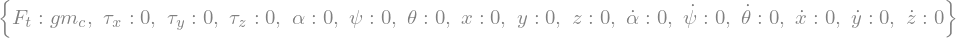

Linearized Matrices
A


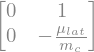

B


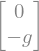

C


D


In [13]:
X = sym.Matrix([
    [y],
    [ydot]
    ])

Y = sym.Matrix([
    [y]
    ])

U = sym.Matrix([
    [theta]
])

equilibrium = {x: 0, y: 0, z: 0, xdot: 0, ydot: 0, zdot: 0, theta: 0, alpha: 0, psi: 0, thetadot: 0, alphadot: 0, psidot: 0, Ft: g*mc, tau_x: 0, tau_y: 0, tau_z: 0}

display(eqns[3:6])
A, B, C, D = linearize_space([eqns[1]], X, Y, U, equilibrium)

print("Linearized Matrices")
print("A")
display(sym.simplify(A))
print("B")
display(sym.simplify(B))
print("C")
display(sym.simplify(C))
print("D")
display(sym.simplify(D))

Equations


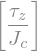

1
0
xdot


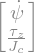

state & input


register & output


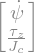

Equilibrium


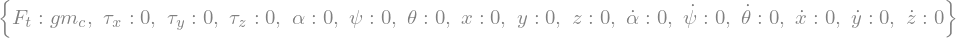

Linearized Matrices
A


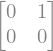

B


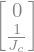

C


D


In [17]:
X = sym.Matrix([
    [psi],
    [psidot]
    ])

Y = sym.Matrix([
    [psi]
    ])

U = sym.Matrix([
    [tau_z]
])

equilibrium = {x: 0, y: 0, z: 0, xdot: 0, ydot: 0, zdot: 0, theta: 0, alpha: 0, psi: 0, thetadot: 0, alphadot: 0, psidot: 0, Ft: g*mc, tau_x: 0, tau_y: 0, tau_z: 0}

A, B, C, D = linearize_space([eqns[5]], X, Y, U, equilibrium)

print("Linearized Matrices")
print("A")
display(sym.simplify(A))
print("B")
display(sym.simplify(B))
print("C")
display(sym.simplify(C))
print("D")
display(sym.simplify(D))

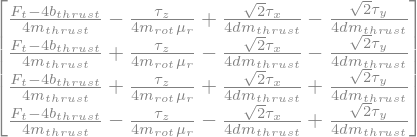

In [14]:
Ft, tau_x, tau_y, tau_z = sym.symbols("F_t, tau_x, tau_y, tau_z")
mt, bt = sym.symbols("m_thrust, b_thrust")
mr, br = sym.symbols("m_rot, b_rot")
t1, t2, t3, t4 = sym.symbols("T_1, T_2, T_3, T_4")
d, mu_r = sym.symbols("d, mu_r")

forces = sym.Matrix([
    [Ft],
    [tau_x],
    [tau_y],
    [tau_z]
])

m = sym.Matrix([
    [mt, mt, mt, mt],
    [d*mt*sym.sqrt(2)/2, -d*mt*sym.sqrt(2)/2, d*mt*sym.sqrt(2)/2, -d*mt*sym.sqrt(2)/2],
    [-d*mt*sym.sqrt(2)/2, -d*mt*sym.sqrt(2)/2, d*mt*sym.sqrt(2)/2, d*mt*sym.sqrt(2)/2],
    [-mu_r*mr, mu_r*mr, mu_r*mr, -mu_r*mr]
])

b = sym.Matrix([
    [4*bt],
    [0],
    [0],
    [0]
])

display(m.inv()@(forces-b))